# Machine Learning for San Diego

In [1]:
# Standard Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import glob

import warnings
warnings.filterwarnings('ignore')

# Word Cloud
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
path = 'C:/Users/Ryan/Documents/Github/ML-SD-Project/'
#path = 'C:/Users/Ryan Luu/Documents/Github/ML-SD-Project/'

all_files = glob.glob(path + "data/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

raw = pd.concat(li, axis=0, ignore_index=True)

In [3]:
raw.head()

,service_request_id,service_request_parent_id,sap_notification_number,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,referred,public_description
0,80477,NaN,NaN,2016-05-20T00:08:00,15.0,Other,TSW,2016-06-03T00:00:00,Closed,NaN,NaN,NaN,NaN,NaN,NaN,Email,NaN,Name : JackEmail : bcjack@hotmail.comAddress...
1,80478,NaN,NaN,2016-05-20T05:04:00,NaN,Parking Meter,TSW,NaN,Referred,32.726553,-117.125296,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,NaN
2,80479,NaN,NaN,2016-05-20T05:05:00,NaN,72 Hour Violation,Parking,NaN,Referred,32.726523,-117.125532,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,NaN
3,80480,NaN,NaN,2016-05-20T05:05:00,NaN,Dead Animal,TSW,NaN,Referred,32.726365,-117.125478,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,NaN
4,80481,NaN,NaN,2016-05-20T05:06:00,0.0,Graffiti Removal,TSW,2016-05-20T00:00:00,Closed,32.726445,-117.125476,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,Test


In [4]:
print("There are " + str(raw.shape[0]) + " observations and " + str(raw.shape[1]) + " variables.")

There are 681427 observations and 18 variables.


# Data Cleaning and Manipulation

In [5]:
# Remove unnecessary columns
raw = raw.drop(["service_request_id", "service_request_parent_id", "sap_notification_number",'referred'], axis=1)

In [6]:
df = raw
# Convert back into datetime64
df['date_requested'] = pd.to_datetime(df['date_requested'])

# Extract date, month, time
df['date'] = df.date_requested.dt.date 
df['month'] = df.date_requested.dt.month
df['time'] = df.date_requested.dt.time

# Better Season
def gs(x):
    if (x == 12) or (x < 3):
        return 'Winter'
    elif (x >= 3) and (x < 6):
        return 'Spring'
    elif (x >= 6) and (x < 9):
        return 'Summer'
    elif (x >= 9) and (x < 12):
        return 'Fall'
    else: 
        return 'Error'

df['season'] = df.month.apply(lambda x: gs(x))

# Time of the Day Variable
def gt(x):
    if (x >= 0) and (x <= 5):
        return 'Past Midnight'
    elif (x > 5) and (x <= 11):
        return 'Morning'
    elif (x > 11) and (x <= 17):
        return 'Afternoon'
    elif (x > 17) and (x <= 23):
        return 'Evening'

df['tod'] = df.date_requested.dt.hour.apply(lambda x: gt(x))

# Make new DOW (day of week) variable
df['dow'] = df.date.apply(lambda x: pd.Timestamp(str(x)).weekday_name)

# Lowercase public description
df.public_description = df.public_description.apply(lambda x: str(x).lower())


# Month 
df.month[df.month == 1] = 'Jan'
df.month[df.month == 2] = 'Feb'
df.month[df.month == 3] = 'Mar'
df.month[df.month == 4] = 'Apr'
df.month[df.month == 5] = 'May'
df.month[df.month == 6] = 'Jun'
df.month[df.month == 7] = 'Jul'
df.month[df.month == 8] = 'Aug'
df.month[df.month == 9] = 'Jan'
df.month[df.month == 10] = 'Oct'
df.month[df.month == 11] = 'Nov'
df.month[df.month == 12] = 'Dec'


#Cleaning and replacing nan in council district with 0
df['council_district'] = df.council_district.fillna(0)
df['council_district'] = df.council_district.astype(np.int64)
df['council_district'] = df.council_district.apply(lambda x: 'district ' + str(x))


# Remove 'Test' observations from public description
df = df[~df.public_description.str.contains('test')]

# Cleaning and Remove nan obsertation in case age days
df = df.dropna(subset=['case_age_days'])
df['case_age_days'] = df.case_age_days.astype(np.int64)

# Setting Conditions for Dataframe
df['lat'] = df['lat'].astype(float)
df['lng'] = df['lng'].astype(float)
df2 = df[(df['lat'] > 32.5444) &
        (df['lat'] < 33.4274) &
        (df['lng'] < -117.0301) &
        (df['lng'] > -117.6126) &
        (df['status'] == 'Closed')]

df2.tail(50)

,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,public_description,date,month,time,season,tod,dow
681355,2019-12-31 18:00:00,6,Missed Collection,ESD Complaint/Report,2020-01-06T00:00:00,Closed,32.760003,-117.072466,district 9,38.0,College Area,NaN,Web,no trash pick up on 12/28/19,2019-12-31,Dec,18:00:00,Winter,Evening,Tuesday
681357,2019-12-31 18:08:00,6,Illegal Dumping,ESD Complaint/Report,2020-01-06T00:00:00,Closed,32.752891,-117.247257,district 2,23.0,Ocean Beach,NaN,Mobile,couches left behind,2019-12-31,Dec,18:08:00,Winter,Evening,Tuesday
681359,2019-12-31 18:39:00,7,Traffic Sign - Maintain,TSW,2020-01-07T00:00:00,Closed,32.802028,-117.049882,district 7,20.0,Navajo,NaN,Mobile,large towable sign. this sign has been here fo...,2019-12-31,Dec,18:39:00,Winter,Evening,Tuesday
681361,2019-12-31 18:46:00,16,Traffic Signal Light Out,TSW,2020-01-16T00:00:00,Closed,32.748417,-117.130108,district 3,28.0,North Park,NaN,Mobile,south side crossing 30th signal does not chang...,2019-12-31,Dec,18:46:00,Winter,Evening,Tuesday
681362,2019-12-31 18:50:00,6,Illegal Dumping,ESD Complaint/Report,2020-01-06T00:00:00,Closed,32.795567,-117.232140,district 2,27.0,Pacific Beach,NaN,Mobile,large furniture in alley.,2019-12-31,Dec,18:50:00,Winter,Evening,Tuesday
681365,2019-12-31 19:25:00,3,Encampment,ESD Complaint/Report,2020-01-03T00:00:00,Closed,32.748133,-117.241502,district 2,23.0,Ocean Beach,NaN,Mobile,homeless man has set up a home using a couch a...,2019-12-31,Dec,19:25:00,Winter,Evening,Tuesday
681367,2019-12-31 19:41:00,13,Pothole,TSW,2020-01-13T00:00:00,Closed,32.741041,-117.129293,district 3,28.0,North Park,NaN,Mobile,pretty large pot hole,2019-12-31,Dec,19:41:00,Winter,Evening,Tuesday
681369,2019-12-31 19:45:00,2,NaN,Parking,2020-01-02T00:00:00,Closed,32.710744,-117.166371,district 3,4.0,Downtown,NaN,Mobile,geofencing off on mlk promenade. scooters mov...,2019-12-31,Dec,19:45:00,Winter,Evening,Tuesday
681370,2019-12-31 20:06:00,0,Pothole,TSW,2019-12-31T00:00:00,Closed,32.666088,-117.057708,district 4,44.0,Skyline-Paradise Hills,NaN,Mobile,nan,2019-12-31,Dec,20:06:00,Winter,Evening,Tuesday
681371,2019-12-31 20:08:00,3,Pothole,TSW,2020-01-03T00:00:00,Closed,32.666004,-117.057844,district 4,44.0,Skyline-Paradise Hills,NaN,Mobile,2 potholes within 10ft on parkside and marmil ...,2019-12-31,Dec,20:08:00,Winter,Evening,Tuesday


In [7]:
#df2.to_csv(path + "data/get_it_done_full.csv", encoding='utf-8', index=False)

# Exploratory Data Analysis

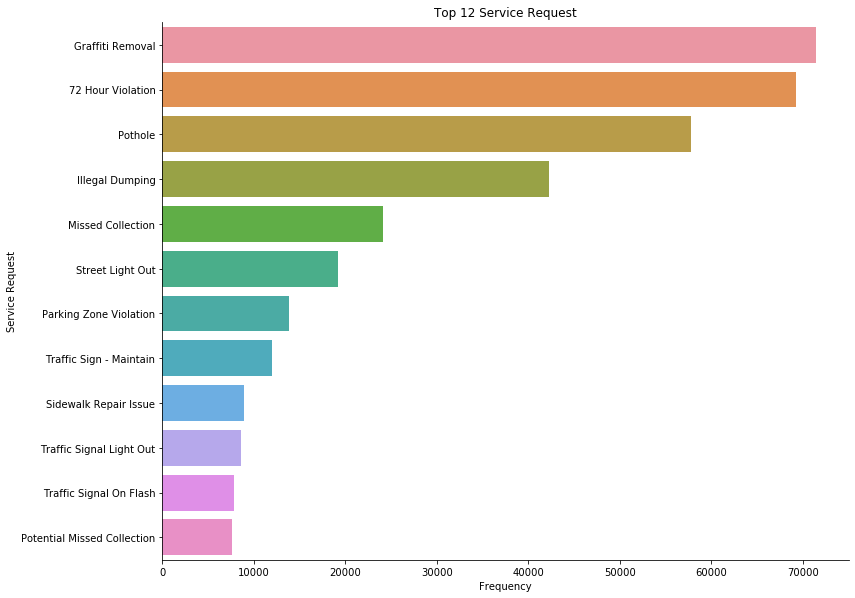

In [8]:
a= sns.catplot(y = 'service_name',
           kind = 'count',
           height = 8,
           aspect = 1.5,
           order = df2.service_name.value_counts().head(12).index,
           data = df2)
plt.title("Top 12 Service Request")
a.set(xlabel='Frequency', ylabel='Service Request')

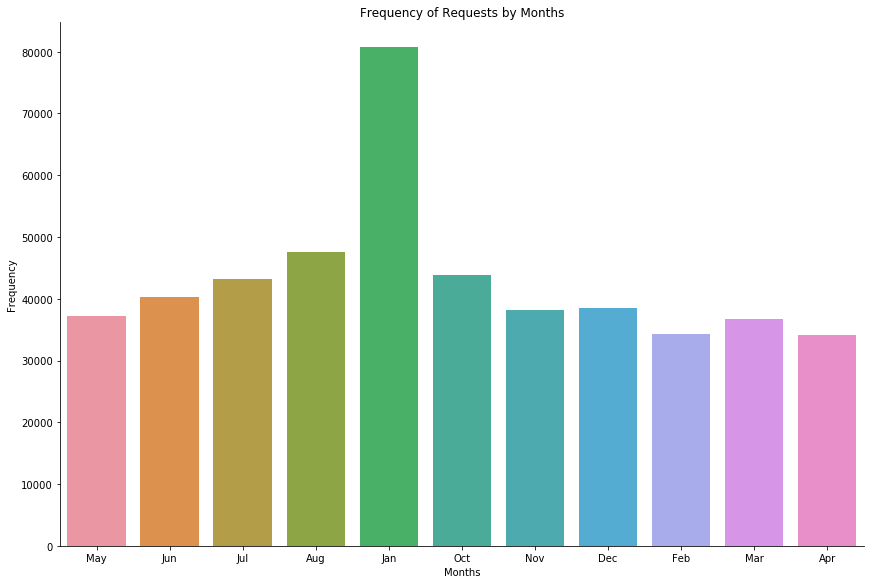

In [9]:
a = sns.catplot(x='month',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Months")
a.set(xlabel="Months",ylabel="Frequency")
plt.show()

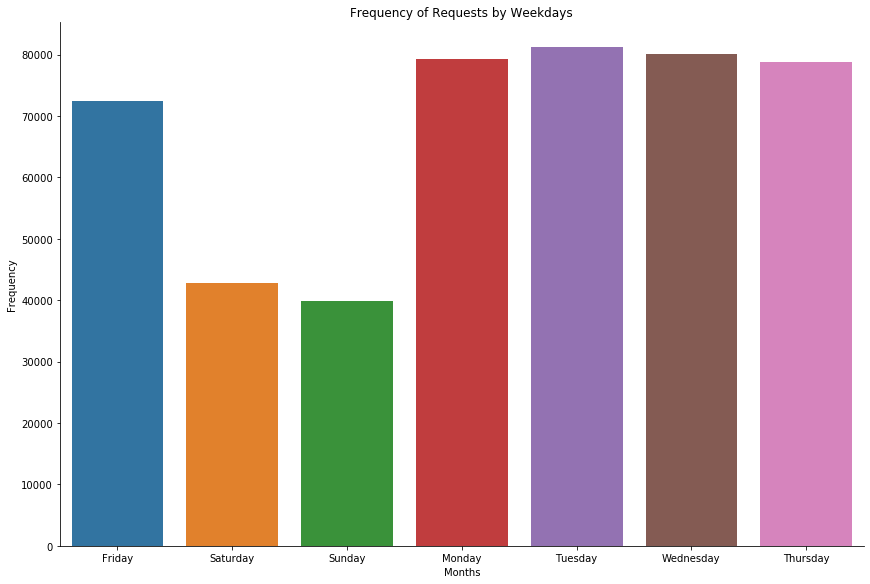

In [10]:
a = sns.catplot(x='dow',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Weekdays")
a.set(xlabel="Months",ylabel="Frequency")
plt.show()

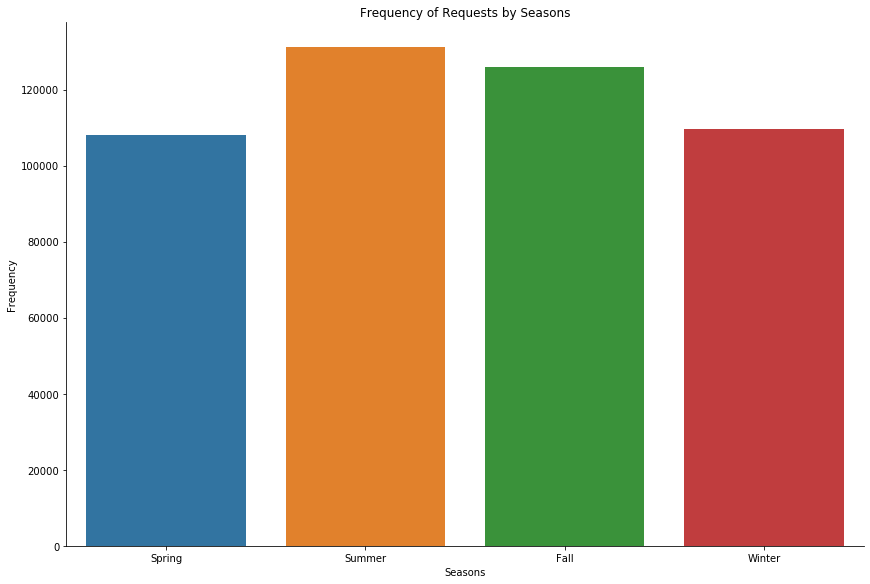

In [11]:
a = sns.catplot(x='season',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Seasons")
a.set(xlabel="Seasons",ylabel="Frequency")
plt.show()

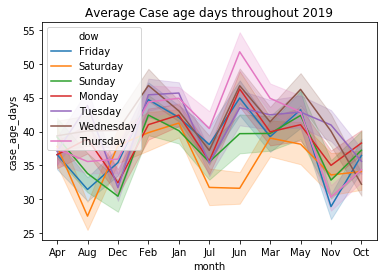

In [12]:
c = sns.lineplot(x="month",
                y="case_age_days",
                hue='dow',
                data=df2
                ).set_title('Average Case age days throughout 2019')
plt.show()

# WordCloud

In [13]:
# Clean nan from public description
desc = ((df2[~df2.public_description.str.contains('nan')])['public_description'])
string = desc.to_string()

In [14]:
s = stopwords.words('english')
print(s)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

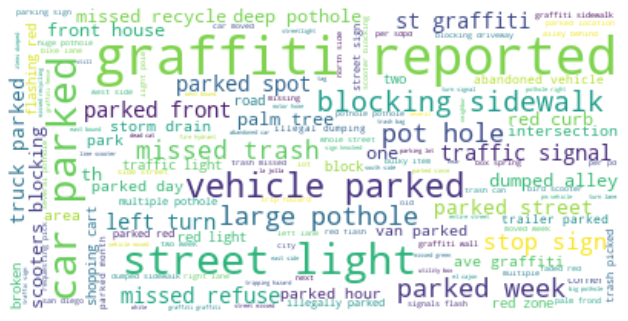

In [15]:
wordcloud = WordCloud(stopwords = s, background_color='white').generate(string)

# Plot
plt.figure(figsize=(11,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preparing New Dataframe

In [16]:
df2.head()

,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,public_description,date,month,time,season,tod,dow
17,2016-05-20 07:19:00,14,Graffiti Removal,TSW,2016-06-03T00:00:00,Closed,32.735047,-117.080075,district 4,57.0,Mid-City:Eastern Area,NaN,Phone,graffiti on the wall in front of the library,2016-05-20,May,07:19:00,Spring,Morning,Friday
32,2016-05-20 09:07:00,0,Damaged Curb,TSW,2016-05-20T00:00:00,Closed,32.747350,-117.128953,district 3,28.0,North Park,NaN,Mobile,nan,2016-05-20,May,09:07:00,Spring,Morning,Friday
33,2016-05-20 09:10:00,537,Storm Water Code Enforcement - Illegal Discharge,TSW,2017-11-08T00:00:00,Closed,32.801410,-117.233518,district 2,27.0,Pacific Beach,NaN,Phone,nan,2016-05-20,May,09:10:00,Spring,Morning,Friday
36,2016-05-20 09:20:00,6,Traffic Sign - Maintain,TSW,2016-05-26T00:00:00,Closed,32.913842,-117.113892,district 5,34.0,Scripps Miramar Ranch,NaN,Phone,construction sign face down in center medien,2016-05-20,May,09:20:00,Spring,Morning,Friday
37,2016-05-20 09:24:00,987,Evaluate for Resurfacing,TSW,2019-01-31T00:00:00,Closed,32.919712,-117.114320,district 5,34.0,Scripps Miramar Ranch,NaN,Phone,lots of cracks and missing asphalt,2016-05-20,May,09:24:00,Spring,Morning,Friday


In [17]:
def norm(x):
    r = (x-min(x))/(max(x)-min(x))
    return(r)

In [18]:
# Convert into categorical
df2['season'] = df['season'].astype('category')
df2['dow'] = df['dow'].astype('category')
df2['case_record_type'] = df['case_record_type'].astype('category')
df2['council_district'] = df['council_district'].astype('category')
df2['month'] = df['month'].astype('category')
df2['case_origin'] = df['case_origin'].astype('category')
df2['service_name'] = df['service_name'].astype('category')

#df2.ftypes 

In [19]:
df3 = pd.get_dummies(df2, columns=['dow'], prefix = [None])
df3 = pd.get_dummies(df3, columns=['month'], prefix = [None])
df3 = pd.get_dummies(df3, columns=['season'], prefix = [None])
df3 = pd.get_dummies(df3, columns=['council_district'], prefix = [None])
df3 = pd.get_dummies(df3, columns =['case_origin'], prefix = [None])
df3 = pd.get_dummies(df3, columns = ['comm_plan_name'], prefix = [None])
df3 = pd.get_dummies(df3, columns = ['tod'], prefix = [None])

df3['normLat'] = norm(df3.lat)
df3['normLng'] = norm(df3.lng)


df3.head()

,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,comm_plan_code,park_name,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
17,2016-05-20 07:19:00,14,Graffiti Removal,TSW,2016-06-03T00:00:00,Closed,32.735047,-117.080075,57.0,NaN,...,0,0,0,0,0,0,1,0,0.252822,0.858126
32,2016-05-20 09:07:00,0,Damaged Curb,TSW,2016-05-20T00:00:00,Closed,32.747350,-117.128953,28.0,NaN,...,0,0,0,0,0,0,1,0,0.269138,0.719367
33,2016-05-20 09:10:00,537,Storm Water Code Enforcement - Illegal Discharge,TSW,2017-11-08T00:00:00,Closed,32.801410,-117.233518,27.0,NaN,...,0,0,0,0,0,0,1,0,0.340828,0.422515
36,2016-05-20 09:20:00,6,Traffic Sign - Maintain,TSW,2016-05-26T00:00:00,Closed,32.913842,-117.113892,34.0,NaN,...,0,0,0,0,0,0,1,0,0.489928,0.762122
37,2016-05-20 09:24:00,987,Evaluate for Resurfacing,TSW,2019-01-31T00:00:00,Closed,32.919712,-117.114320,34.0,NaN,...,0,0,0,0,0,0,1,0,0.497712,0.760908


In [20]:
# Drop column not needed for training
df3 = df3.drop(["date_requested", "case_age_days", "service_name",'date_updated', 'status',
                'lat','lng','comm_plan_code','park_name',
               'public_description','date','time'], axis=1)

In [21]:
df3.head()

,case_record_type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr,Aug,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
17,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.252822,0.858126
32,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.269138,0.719367
33,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.340828,0.422515
36,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.489928,0.762122
37,TSW,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.497712,0.760908


In [22]:
df3.case_record_type.unique()

[TSW, Parking, ESD Complaint/Report, Traffic Engineering, DSD, TSW ROW, Storm Water Code Enforcement]
Categories (7, object): [TSW, Parking, ESD Complaint/Report, Traffic Engineering, DSD, TSW ROW, Storm Water Code Enforcement]

In [23]:
def dep(x):
    if x == 'TSW':
        return 0
    if x == 'Parking':
        return 1
    if x == 'ESD Complaint/Report':
        return 2
    if x == 'Traffic Engineering':
        return 3
    if x == 'DSD':
        return 4
    if x == 'TSW ROW':
        return 5
    if x == 'Storm Water Code Enforcement':
        return 6
    
df3.case_record_type = df3.case_record_type.apply(lambda x: dep(x))

In [24]:
df3.tail()

,case_record_type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr,Aug,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
681420,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.338846,0.390570
681422,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.216192,0.820778
681423,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.295427,0.736812
681424,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.274173,0.375375
681425,2,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.218476,0.917324


# Test and Train

In [25]:
#!pip3 install tensorflow

In [26]:
# ML Packages
import tensorflow as tf
from tensorflow import keras

import scipy
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import confusion_matrix

In [27]:
np.random.seed(1234)

split = np.random.rand(len(df3)) < 0.7
train = df3[split]
test = df3[~split]

# Synthetic Minority Oversampling Technique

In [28]:
print('Class Distribution %s' % Counter(train.case_record_type))

Class Distribution Counter({0: 187464, 2: 70906, 1: 62155, 3: 7147, 6: 3014, 5: 969, 4: 900})


In [29]:
x = (187464)/(187464 + 70906 + 62155 + 7147 + 3014 + 969 + 900)
print("Guessing strictly TSW will yield a " + str(x) + " accuracy.")

Guessing strictly TSW will yield a 0.5637082587842612 accuracy.


In [30]:
# Change train into np.array since Tensorflow works w array
train_nparray = train.values


trainx = train_nparray[:,1:]
trainy = train_nparray[:,[0]]

# Convert to float
trainx = trainx.astype('float32')
trainy = trainy.astype('float32')

In [31]:
sm = SMOTE(random_state=42)
trainx_res, trainy_res = sm.fit_resample(trainx, trainy)

In [32]:
print('New Class Distribution %s' % Counter(trainy_res)) 

New Class Distribution Counter({0.0: 187464, 3.0: 187464, 2.0: 187464, 5.0: 187464, 1.0: 187464, 6.0: 187464, 4.0: 187464})


In [33]:
print('Now, each case record type has an equal probability of being predicted of ' + str(1/7))

Now, each case record type has an equal probability of being predicted of 0.14285714285714285


# Training Neural Network

In [34]:
train_nparray.shape

(332555, 126)

In [35]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(125, )),
    keras.layers.Dense(128, activation=tf.nn.relu), #Rectified linear unit, common activation function
    #keras.layers.Dense(1, activation=tf.nn.relu),
    keras.layers.Dense(7, activation=tf.nn.softmax) # 7 classes in predicting service request type
])

In [36]:
model.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy', # multiclass prediction
             metrics=['accuracy'])

In [37]:
# fit() -> trains the model
model.fit(trainx_res, trainy_res, epochs=10)

Train on 1312248 samples
Epoch 1/10
1312248/1312248 [==============================] - 35s 27us/sample - loss: 1.0739 - accuracy: 0.6006
Epoch 2/10
1312248/1312248 [==============================] - 37s 28us/sample - loss: 0.8786 - accuracy: 0.6666
Epoch 3/10
1312248/1312248 [==============================] - 36s 28us/sample - loss: 0.8324 - accuracy: 0.6820
Epoch 4/10
1312248/1312248 [==============================] - 35s 27us/sample - loss: 0.8088 - accuracy: 0.6899
Epoch 5/10
1312248/1312248 [==============================] - 35s 26us/sample - loss: 0.7939 - accuracy: 0.6944
Epoch 6/10
1312248/1312248 [==============================] - 36s 27us/sample - loss: 0.7827 - accuracy: 0.6983
Epoch 7/10
1312248/1312248 [==============================] - 37s 28us/sample - loss: 0.7746 - accuracy: 0.7011
Epoch 8/10
1312248/1312248 [==============================] - 37s 28us/sample - loss: 0.7684 - accuracy: 0.7032
Epoch 9/10
1312248/1312248 [==============================] - 40s 30us/sample -

In [38]:
train_loss, train_acc = model.evaluate(trainx_res, trainy_res)

print('Train accuracy:', train_acc)

1312248/1312248 [==============================] - 24s 18us/sample - loss: 0.7500 - accuracy: 0.7098
Train accuracy: 0.70978886


# Checking with Test Data

In [39]:
# Change test into np.array since Tensorflow works w array
test_nparray = test.values

testx = test_nparray[:,1:]
testy = test_nparray[:,[0]]

# Convert to float
testx = testx.astype('float32')
testy = testy.astype('float32')

In [40]:
test_loss, test_acc = model.evaluate(testx, testy)

print('Test accuracy:', test_acc)

141979/141979 [==============================] - 3s 18us/sample - loss: 1.1105 - accuracy: 0.5254
Test accuracy: 0.5253946


# Prediction Output

In [41]:
labels = ['TSW 0', 'Parking 1', 'ESD Complaint/Report 2', 'Traffic Engineering 3', 'DSD 4', 'TSW ROW 5', 'Storm Water Code Enforcement 6']
print(labels)

['TSW 0', 'Parking 1', 'ESD Complaint/Report 2', 'Traffic Engineering 3', 'DSD 4', 'TSW ROW 5', 'Storm Water Code Enforcement 6']


In [48]:
test

,case_record_type,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Apr,Aug,...,Torrey Pines,University,Uptown,Via De La Valle,Afternoon,Evening,Morning,Past Midnight,normLat,normLng
36,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.489928,0.762122
37,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.497712,0.760908
41,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.262867,0.762335
46,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.496811,0.574781
47,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.221526,0.633619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681413,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.329726,0.376644
681414,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.215350,0.928234
681415,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.474287,0.688238
681422,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.216192,0.820778


In [42]:
predictions = model.predict_proba(testx)
predictiondf = pd.DataFrame(data=predictions)
predictiondf.rename(columns={i:j for i,j in zip(predictiondf.columns,labels)}, inplace = True)
predictiondf['Class_Prediction'] = [labels[np.argmax(i)] for i in predictions]
predictiondf['Pred'] = [int(labels[np.argmax(i)][-1:]) for i in predictions]
predictiondf['Prob'] = [np.max(i) for i in predictions]
predictiondf['Actual'] = testy.astype(int)
predictiondf['Score'] = np.where(predictiondf.Actual == predictiondf.Pred, True, False)

predictiondf.head(20)

,TSW 0,Parking 1,ESD Complaint/Report 2,Traffic Engineering 3,DSD 4,TSW ROW 5,Storm Water Code Enforcement 6,Class_Prediction,Pred,Prob,Actual,Score
0,0.744802,0.005293,0.246141,0.000848,4.870022e-16,2.576339e-06,2.913104e-03,TSW 0,0,0.744802,0,True
1,0.744460,0.005198,0.246750,0.000830,4.509304e-16,2.650505e-06,2.758035e-03,TSW 0,0,0.744460,0,True
2,0.171317,0.005724,0.820767,0.001991,7.288853e-13,1.462462e-04,5.364208e-05,ESD Complaint/Report 2,2,0.820767,0,False
3,0.516272,0.002196,0.073669,0.064102,1.496635e-10,3.065965e-08,3.437620e-01,TSW 0,0,0.516272,0,True
4,0.390578,0.267141,0.129941,0.195810,3.657600e-03,2.988431e-09,1.287280e-02,TSW 0,0,0.390578,0,True
5,0.971914,0.001152,0.026877,0.000016,1.191085e-18,7.078921e-11,4.120920e-05,TSW 0,0,0.971914,0,True
6,0.900985,0.010873,0.087897,0.000227,6.730332e-15,1.537434e-09,1.737677e-05,TSW 0,0,0.900985,0,True
7,0.877412,0.003162,0.117998,0.001423,6.302738e-17,4.221337e-08,4.591247e-06,TSW 0,0,0.877412,0,True
8,0.285520,0.005050,0.665005,0.034486,1.086648e-16,1.268832e-07,9.938004e-03,ESD Complaint/Report 2,2,0.665005,0,False
9,0.886248,0.007706,0.104165,0.001686,5.182730e-14,2.198732e-08,1.951282e-04,TSW 0,0,0.886248,0,True


In [60]:
t = predictiondf.Score.value_counts()[1]
f = predictiondf.Score.value_counts()[0]
a = t/(t+f)
print('Model Accuracy: ' + str(a))

Model Accuracy: 0.5253946006099494


# Confusion Matrix

In [43]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [44]:
predict = predictiondf.Pred.values
actual = predictiondf.Actual.values

In [45]:
def cm_report(x,y):
    results = confusion_matrix(x,y)
    print('Confusion Matrix')
    print()
    print(results)
    print()
    print('Accuracy Score: ', accuracy_score(x,y))
    print()
    print('Report')
    print(classification_report(x,y))

In [46]:
cm_report(actual,predict)

Confusion Matrix

[[39559 22660 10803  2324  2021  1591  1141]
 [ 6056 16621  1918   698   726   675   172]
 [ 4661  6489 17194   410   531   429   229]
 [  906  1152   278   563    72    46    44]
 [  114   131    42     6    37    11     5]
 [  129   154    24     6     9   110    12]
 [  320   196   121    34    19    19   511]]

Accuracy Score:  0.5253946006099494

Report
              precision    recall  f1-score   support

           0       0.76      0.49      0.60     80099
           1       0.35      0.62      0.45     26866
           2       0.57      0.57      0.57     29943
           3       0.14      0.18      0.16      3061
           4       0.01      0.11      0.02       346
           5       0.04      0.25      0.07       444
           6       0.24      0.42      0.31      1220

    accuracy                           0.53    141979
   macro avg       0.30      0.38      0.31    141979
weighted avg       0.62      0.53      0.55    141979



# Let's Try Undersampling?

1. Random under-sampling for the majority class - can potentially lead to loss of information. But if the example of the majority class are near to others, might yield good results.

2. Near Miss - Attemps to fix the issue of potential information loss; the method calculates the distances between all instances of the majority class and the instances of the minority class. Then k instances of the majority class that have the smallest distances to those in the minority class are selected. 

3. Condensed Nearest Neighbor Rule (CNN) - To avoid losing potentially useful data. 

4. TomekLinks

5. Edited Nearest Neightbor Rule (ENN)

6. Neighborhood Cleaning Rule

7. Cluster Centroids

# Limitations and Assumptions

The dataset does not account for duplicate requests. For example, if there was a street light out on a populated intersection, chances are many people may report the same problem. However, if there were a dead animal in small alley, not that many would report it. 

Just because the street light got more requests does not mean that it occurs more often than other service type requests.

We also have to keep in mind that people report what they want to report. For example, some people may not want to report Graffiti if they think it looks nice. If they report it, it would get taken down so they don't report it.
+